In [27]:
# Smart City Traffic Patterns:

import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import time
import seaborn as sns
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
test = pd.read_csv('test_data.csv')
train = pd.read_csv('train_data.csv')
head = train.head(5)
tail = train.tail(5)

def data_inf(data,name):
    print('rows: ',data.shape[0],' ,columns: ',data.shape[1],' in',name,'\n')
    data.info()
    print('\n')
data_inf(train,'Train')
# display(train.head(5).append(train.tail(5)))
concatenated_df = pd.concat([head, tail])
print(concatenated_df)


rows:  48120  ,columns:  4  in Train 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


                  DateTime  Junction  Vehicles           ID
0      2015-11-01 00:00:00         1        15  20151101001
1      2015-11-01 01:00:00         1        13  20151101011
2      2015-11-01 02:00:00         1        10  20151101021
3      2015-11-01 03:00:00         1         7  20151101031
4      2015-11-01 04:00:00         1         9  20151101041
48115  2017-06-30 19:00:00         4        11  20170630194
48116  2017-06-30 20:00:00         4        30  20170630204
48117  2017-06-30 21:00:00         4        16  20170630214
48118  2017-06-30 22:00:00       

In [11]:
head1 = test.head(5)
tail1 = test.tail(5)
data_inf(test,"Test")
concatenated_df = pd.concat([head, tail])
print(concatenated_df)

rows:  11808  ,columns:  3  in Test 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  11808 non-null  object
 1   Junction  11808 non-null  int64 
 2   ID        11808 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 276.9+ KB


                  DateTime  Junction  Vehicles           ID
0      2015-11-01 00:00:00         1        15  20151101001
1      2015-11-01 01:00:00         1        13  20151101011
2      2015-11-01 02:00:00         1        10  20151101021
3      2015-11-01 03:00:00         1         7  20151101031
4      2015-11-01 04:00:00         1         9  20151101041
48115  2017-06-30 19:00:00         4        11  20170630194
48116  2017-06-30 20:00:00         4        30  20170630204
48117  2017-06-30 21:00:00         4        16  20170630214
48118  2017-06-30 22:00:00         4        22  20170630224
48119  201

In [12]:
display(train.describe())
display(train.describe(include = 'object'))

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


,DateTime
count,48120
unique,14592
top,2017-06-30 23:00:00
freq,4


In [13]:
print('Before Dropping ',train.shape[0])
train.drop_duplicates(keep="first", inplace=True) 
print('After Dropping ',train.shape[0])

Before Dropping  48120
After Dropping  48120


In [14]:
if(train.isnull().sum().sum()==0):
    print('no missing values in train')
else:
    train.fillna(method='ffill',inplace=True)
if(test.isnull().sum().sum()==0):
    print('no missing values in test')    
else:
    test.fillna(method='ffill',inplace=True)

no missing values in train
no missing values in test


In [15]:
print('Before Converting :',train['DateTime'].dtype)
train['DateTime'] = pd.to_datetime(train['DateTime'],errors='coerce')
test['DateTime'] = pd.to_datetime(test['DateTime'])
print('After Converting :',train['DateTime'].dtype)

Before Converting : object
After Converting : datetime64[ns]


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB


In [17]:
# Exploring more features  
train["Year"]= train['DateTime'].dt.year  
train["Month"]= train['DateTime'].dt.month  
train["Date_no"]= train['DateTime'].dt.day  
train["Hour"]= train['DateTime'].dt.hour  
train["Day"]= train.DateTime.dt.strftime("%A")

test["Year"]= test['DateTime'].dt.year  
test["Month"]= test['DateTime'].dt.month  
test["Date_no"]= test['DateTime'].dt.day  
test["Hour"]= test['DateTime'].dt.hour  
test["Day"]= test.DateTime.dt.strftime("%A")

In [18]:
train.head()

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday


In [19]:
test.head()

,DateTime,Junction,ID,Year,Month,Date_no,Hour,Day
0,2017-07-01 00:00:00,1,20170701001,2017,7,1,0,Saturday
1,2017-07-01 01:00:00,1,20170701011,2017,7,1,1,Saturday
2,2017-07-01 02:00:00,1,20170701021,2017,7,1,2,Saturday
3,2017-07-01 03:00:00,1,20170701031,2017,7,1,3,Saturday
4,2017-07-01 04:00:00,1,20170701041,2017,7,1,4,Saturday


Text(0.5, 0, 'DateTime')

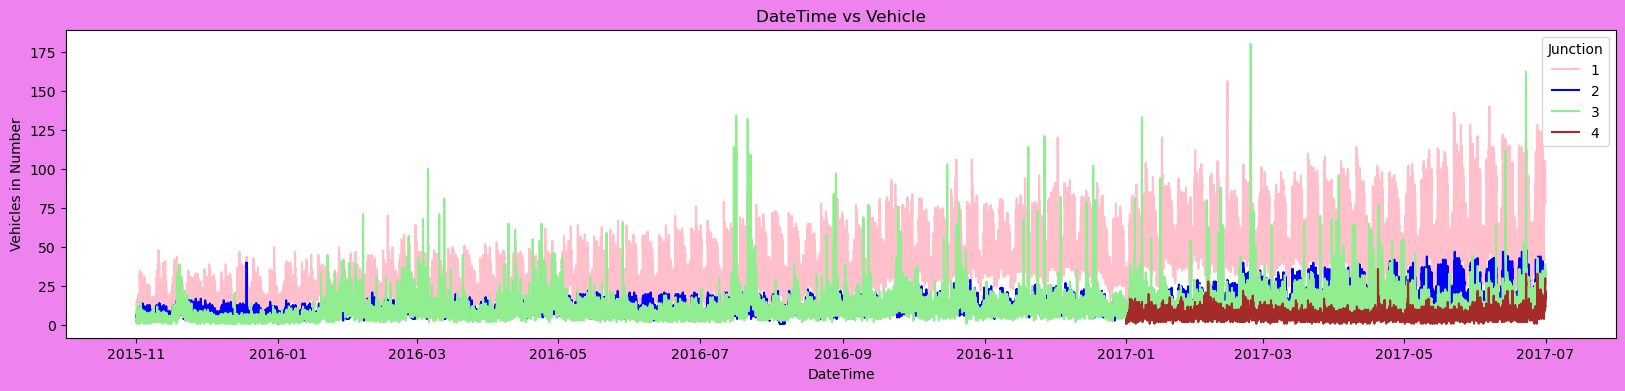

In [20]:
# time series plot
colors = [ "pink","blue","lightgreen","brown"]
plt.figure(figsize=(20,4),facecolor="violet")  
time_series=sns.lineplot(x=train['DateTime'],y="Vehicles",data=train, hue="Junction", palette=colors)  
time_series.set_title("DateTime vs Vehicle")  
time_series.set_ylabel("Vehicles in Number")  
time_series.set_xlabel("DateTime") 

Text(0.5, 0, 'Date')

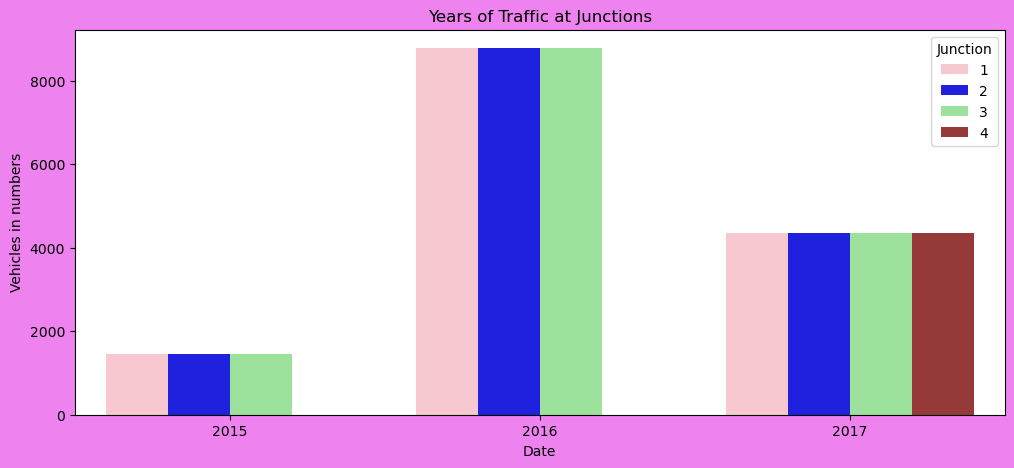

In [21]:
#years of traffic at junction
plt.figure(figsize=(12,5),facecolor="violet")  
colors = [ "pink","blue","lightgreen","brown"]
count = sns.countplot(data=train, x =train["Year"], hue="Junction", palette=colors)  
count.set_title("Years of Traffic at Junctions")  
count.set_ylabel("Vehicles in numbers")  
count.set_xlabel("Date") 

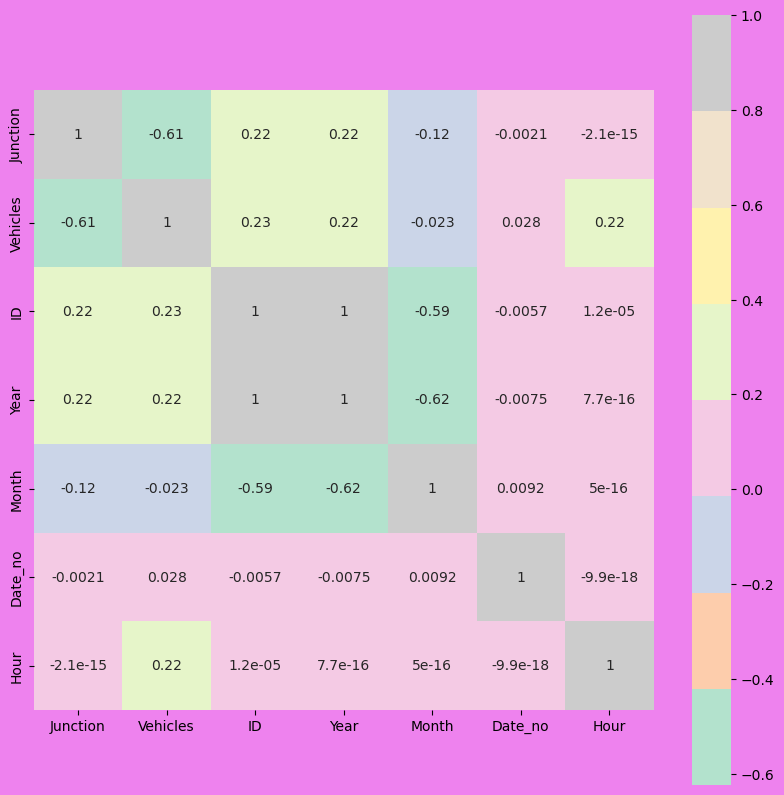

In [22]:
#heat map
numeric_train = train.select_dtypes(include=['number'])
corrmat = numeric_train.corr() 
plt.subplots(figsize=(10,10),facecolor="violet")  
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True )
plt.show()

In [23]:
def datetounix1(df):
    # Initialising unixtime list
    unixtime = []
    
    # Running a loop for converting Date to seconds
    for date in df['DateTime']:
        unixtime.append(time.mktime(date.timetuple()))
    
    # Replacing Date with unixtime list
    df['DateTime'] = unixtime
    return(df)

In [24]:
train.head()

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday


In [28]:
# Define a function to convert datetime objects to Unix timestamps
def datetounix1(df):
    # Convert 'DateTime' column to datetime type if it's not already
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    
    # Drop rows with NaT (missing) values in 'DateTime' column
    df = df.dropna(subset=['DateTime'])
    
    unixtime = []
    # Running a loop for converting Date to seconds
    for date in df['DateTime']:
        unixtime.append(time.mktime(date.timetuple()))
    
    # Replacing 'DateTime' with Unix timestamps
    df['DateTime'] = unixtime
    return df

# Assuming you have DataFrame 'train' and 'test'
train_features = datetounix1(train.drop(['Vehicles'], axis=1))
test_features = datetounix1(test)

# Store Features / Predictors in array :
X = train_features  
X_valid = test_features

# One Hot Encoding - Using Dummies :
X = pd.get_dummies(X)
X_valid = pd.get_dummies(X_valid)

# Store target 'Vehicles' in y array :
y = train['Vehicles'].to_frame()

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=512)


In [29]:
# Convert the dataset to LightGBM data format
train_data = lgb.Dataset(X_train, label=y_train)

# Set the parameters for the LightGBM regression model
params = {
    'objective': 'regression',
    'metric': 'rmse'  # Root Mean Squared Error
}

# Train the LightGBM regression model
model = lgb.train(params,train_data, num_boost_round=100)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the evaluation metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 32240, number of used features: 3
[LightGBM] [Info] Start training from score 22.676458
Mean Squared Error: 103.88236827867333
Mean Absolute Error: 6.755753161500445
R2 Score: 0.7642804852771554


In [30]:
# Create a Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)
#for i in range(15880):
#    print(y_pred[i],y_test.iloc[i])

C:\Users\dhyey\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [31]:
# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the evaluation metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)

Mean Squared Error: 19.39431168765743
Mean Absolute Error: 2.8643148614609566
R2 Score: 0.9559923612144223
